In [ ]:
!pip install transformers peft accelerate datasets sentencepiece --quiet

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/My Drive/_NLP/_NLP_Project/ModelTraining')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Qwen

In [ ]:
# --- Imports ---
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

In [ ]:
# --- Load Pretrained Qwen1.5 Model ---
model_name = "Qwen/Qwen1.5-0.5B-Chat"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,   # <<< Load in bf16 for training
    device_map="auto",            # Auto load on GPU
    trust_remote_code=True
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [ ]:
# # --- Apply LoRA ---
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)


model = get_peft_model(model, lora_config)

In [ ]:
# --- Load Dataset ---
dataset = load_dataset("NebulaSense/Legal_Clause_Instructions")

In [ ]:
# --- Preprocessing Functions ---
max_seq_length = 1024

def get_instruction_prompt(instruction_type, instruction, input_text=None):
    base_prompt = (
        "### Instruction:\n"
        "You are drafting or modifying a contract clause based on the following requirements:\n"
        "- Write in formal legal English.\n"
        "- Do not include headings or titles.\n"
        "- Use bullet points if necessary.\n"
        "- Focus on confidentiality, data, privacy, termination, payment, or non-compete terms.\n"
        "- Avoid repeating the same point twice.\n"
        "- END the clause formally and completely\n"
    )
    if instruction_type == "generation":
        return f"{base_prompt}Task: Generate a new contract clause.\nInput: {instruction}\n### Response:"
    elif instruction_type == "modification":
        return f"{base_prompt}Task: Modify the provided contract clause.\nInput Instruction: {instruction}\nClause to Modify: {input_text}\n### Response:"
    else:
        raise ValueError(f"Unknown instruction_type: {instruction_type}")

In [ ]:
def preprocess_function(examples):
    valid_indices = [
        i for i, instr_type in enumerate(examples["Instruction_Type"])
        if instr_type in ["generation", "modification"]
    ]

    filtered_examples = {
        key: [value[i] for i in valid_indices]
        for key, value in examples.items()
    }

    inputs = [
        get_instruction_prompt(instr_type, instr, input_text)
        for instr_type, instr, input_text in zip(
            filtered_examples["Instruction_Type"],
            filtered_examples["Instruction"],
            filtered_examples.get("Input", [None] * len(filtered_examples["Instruction"])),
        )
    ]
    targets = filtered_examples["Output"]

    valid_inputs_and_targets = [(inp, tgt) for inp, tgt in zip(inputs, targets) if inp and tgt]
    inputs, targets = zip(*valid_inputs_and_targets) if valid_inputs_and_targets else ([], [])

    if not inputs:
        return {}

    # For Causal LM: input = prompt + expected output
    full_texts = [
        inp + "\n" + tgt
        for inp, tgt in zip(inputs, targets)
    ]

    model_inputs = tokenizer(
        list(full_texts),
        max_length=max_seq_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    return {
        "input_ids": model_inputs["input_ids"],
        "attention_mask": model_inputs["attention_mask"],
        "labels": model_inputs["input_ids"].clone(),
    }


In [ ]:
# --- Tokenize Dataset ---
tokenized_dataset = dataset["train"].map(
    preprocess_function,
    batched=True,
    remove_columns=["Instruction_Type", "Instruction", "Input", "Output"],
    num_proc=1,  # Safe on Mac/Remote code models
    load_from_cache_file=False
)


Map:   0%|          | 0/4557 [00:00<?, ? examples/s]

In [ ]:
!pip install bert_score

In [ ]:
from bert_score import score as bert_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Decode predictions and labels
    pred_texts = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    label_texts = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Remove empty strings
    pred_texts = [text.strip() for text in pred_texts if text.strip()]
    label_texts = [text.strip() for text in label_texts if text.strip()]

    # BERTScore calculation
    P, R, F1 = bert_score(pred_texts, label_texts, lang="en", verbose=False)

    return {
        "BERTScore_P": P.mean().item(),
        "BERTScore_R": R.mean().item(),
        "BERTScore_F1": F1.mean().item(),
    }


In [ ]:
# --- Data Collator ---
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

In [ ]:
# --- Training Arguments ---
training_args = TrainingArguments(
    output_dir="./qwen_outputs_lora",
    eval_strategy="steps",
    eval_steps=500,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    learning_rate=5e-4,  # <<< Slightly higher LR for LoRA
    weight_decay=0.01,
    bf16=True,           # <<< Use bf16
    fp16=False,          # <<< Disable fp16
    report_to="none",
    push_to_hub=False
)

In [ ]:
# --- Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_dataset.select(range(500)),
    data_collator=data_collator,
    tokenizer=tokenizer,
)

<ipython-input-23-ec0e4c336421>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# --- Train ---
trainer.train()

# --- Save only the LoRA adapters ---
model.save_pretrained("./qwen_outputs_lora_adapter_only")
tokenizer.save_pretrained("./qwen_outputs_lora_adapter_only")


Step,Training Loss,Validation Loss
500,0.557900,0.525193
1000,0.534000,0.480104
1500,0.480900,0.448638
2000,0.475800,0.421639
2500,0.407600,0.393707
3000,0.411900,0.376870


TrainOutput(global_step=3420, training_loss=0.4734102721799884, metrics={'train_runtime': 651.4547, 'train_samples_per_second': 20.985, 'train_steps_per_second': 5.25, 'total_flos': 2.603649496566989e+16, 'train_loss': 0.4734102721799884, 'epoch': 3.0})

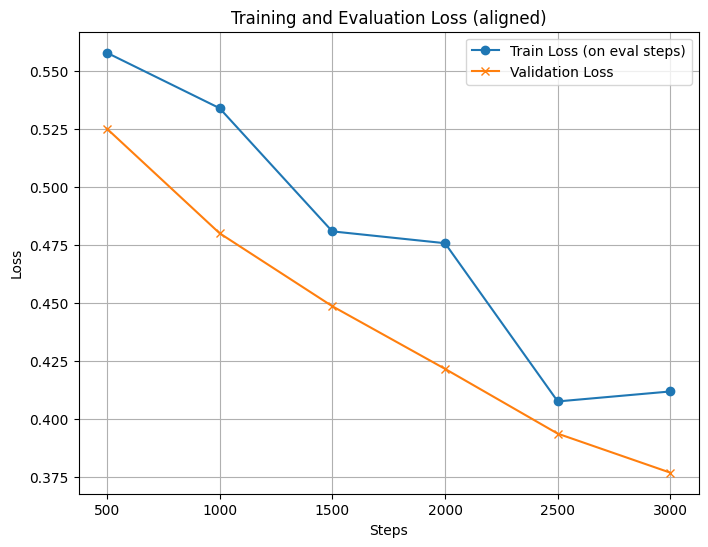

In [ ]:
import matplotlib.pyplot as plt

train_loss_steps = []
train_losses = []
eval_loss_steps = []
eval_losses = []

for log in trainer.state.log_history:
    if 'loss' in log.keys() and 'step' in log.keys():
        train_loss_steps.append(log['step'])
        train_losses.append(log['loss'])
    if 'eval_loss' in log.keys() and 'step' in log.keys():
        eval_loss_steps.append(log['step'])
        eval_losses.append(log['eval_loss'])


filtered_train_losses = []
for s in eval_loss_steps:
    if s in train_loss_steps:
        idx = train_loss_steps.index(s)
        filtered_train_losses.append(train_losses[idx])
    else:
        filtered_train_losses.append(None)

plt.figure(figsize=(8,6))
plt.plot(eval_loss_steps, filtered_train_losses, label="Train Loss (on eval steps)", marker='o')
plt.plot(eval_loss_steps, eval_losses, label="Validation Loss", marker='x')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss (aligned)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# # --- Save Model Locally ---
output_dir = "./qwen_finetuned_model_nca"

trainer.save_model(output_dir)  # Save both model and tokenizer
tokenizer.save_pretrained(output_dir)

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# 1. Load dataset
dataset = load_dataset("NebulaSense/Legal_Clause_Instructions")
test_dataset = dataset["test"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# 3. Prepare input texts
input_texts = []
reference_outputs = []

for example in test_dataset:
    instr_type = example["Instruction_Type"]
    instruction = example["Instruction"]
    input_field = example.get("Input", None)

    if instr_type not in ["generation", "modification"]:
        continue

    prompt = get_instruction_prompt(instr_type, instruction, input_field)

    if prompt and example["Output"]:
        input_texts.append(prompt)
        reference_outputs.append(example["Output"])


In [ ]:
from tqdm import tqdm

batch_size = 16
generated_texts = []

batches = [input_texts[i:i+batch_size] for i in range(0, len(input_texts), batch_size)]

for batch in tqdm(batches, desc="Batch Generating..."):
    inputs = tokenizer(
        batch,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=512,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            repetition_penalty=1.1,
            no_repeat_ngram_size=4,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )


    batch_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)


    for idx, pred_text in enumerate(batch_preds):
        prompt = batch[idx]
        if pred_text.lower().startswith(prompt.lower().strip()):
            pred_text = pred_text[len(prompt):].strip()
        generated_texts.append(pred_text)

Batch Generating...: 100%|██████████| 32/32 [15:32<00:00, 29.14s/it]


In [ ]:
from bert_score import score

P, R, F1 = score(generated_texts, reference_outputs, lang="en", verbose=True)

print(f"Precision: {P.mean().item():.4f}")
print(f"Recall: {R.mean().item():.4f}")
print(f"F1: {F1.mean().item():.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/16 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/8 [00:00<?, ?it/s]

done in 13.45 seconds, 37.70 sentences/sec
Precision: 0.8415
Recall: 0.8764
F1: 0.8581


In [ ]:
input_text = """### Instruction:
Generate a salary clause for a employee agreement for ABC Company And John Smith.
montly salary is 50000 Baht, starting date is 01.06.2025
END the clause formally and completely.
Bullet point with correct number.
### Response:"""

inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

outputs = model.generate(
    **inputs,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    early_stopping=True
)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Optional cleaning
generated_text = generated_text.split("{}")[0].strip()

print(generated_text)


In [3]:
# !pip install spacy

  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached typer-0.15.2-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic-2.11.3-py3-none-any.whl.metadata (65 kB)
  Using cached langcodes-3.5.0-py3-none-any.whl.metadata (29 kB)
  Using cached language_data-1.3.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached typing_inspection-0.4.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached confection-0.1.5-py3-none-any.whl.metadata (19 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB

In [ ]:
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")


def remove_incomplete_sentence_and_add_bullet_points(text):
    # Process the text using spaCy
    doc = nlp(text)

    # Split the text into sentences
    sentences = list(doc.sents)
    
    # Remove empty numbered sentences (e.g., "2." with no content after it)
    sentences = [sent for sent in sentences if not (sent.text.strip().isdigit() or (sent.text.strip()[0].isdigit() and len(sent.text.strip()) <= 3))]

    # Rebuild the text with bullet points and numbered sentences
    cleaned_text = "<ul>"

    for sent in sentences:
        sentence_text = sent.text.strip()

        # Check if the sentence ends with a colon (e.g., "Job Title and Responsibilities:")
        if sentence_text.endswith(":"):
            # Make the part before the colon bold
            part_before_colon = sentence_text.split(":", 1)[0]
            part_after_colon = sentence_text.split(":", 1)[1].strip()
            cleaned_text += f"<li><strong>{part_before_colon}:</strong> {part_after_colon}</li>"
        elif sentence_text and sentence_text[0].isdigit() and sentence_text[1] == ".":
            # For numbered sentences, retain the number and add it as part of the list item
            cleaned_text += f"<li>{sentence_text}</li>"
        else:
            # For unnumbered sentences, add a bullet point
            cleaned_text += f"<li>{sentence_text}</li>"

    cleaned_text += "</ul>"
    
    return cleaned_text

# Example usage
generated_text = """
1. Definition of Confidential Information: "Confidential Information" means any and all information disclosed by the Asian Institute to the ABC Organisation, whether in writing, orally, or by any other means, that is designated as confidential or that reasonably should be understood to be confidential given the nature of the information and the circumstances of disclosure.
2. 
Obligations of the Receiving Party:
The Receiving Party agrees to hold the Confidential Information in strict confidence and not to disclose it to any third party without the prior written consent of the Asian Institute.
The Receiving Party shall use the Confidential Information solely for the purpose of evaluating a potential business relationship between the two parties.
3. 
Exceptions: The obligations of the Receiving Party under this NDA shall not apply to any Confidential Information that: (a) is or becomes generally available to the public through no fault of the Receiving Party; (b) was in the possession of the Receiving Party prior to its disclosure by the Asian Institute; (c) is rightfully obtained by the Receiving Party from a third party without restriction on disclosure; or (d) is independently developed by the Receiving Party without reference to the Confidential Information.
4. 
Term: The obligations of the Receiving Party under this NDA shall survive for a period of five (5) years from the date of disclosure of the Confidential Information.
"""

cleaned_text = remove_incomplete_sentence_and_add_bullet_points(generated_text)
print(cleaned_text)


OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.